## PLANS AND TODO:

Get basis using NMF on regular season data for players who played in the playoffs. removing players who took fewer than 50 shots in reg and 2 in playoffs
* Done more anal needed

use this basis to characterize each player during regular season and playoffs to compare their shooting styles during each interval of time
* Done, but more written anal needed
    
Possibly use KNN to determine which players play similarly, group them 

Possibly only look at shots that are more than 1 ft from the hoop to actually look at shots rather than layups and dunks since theres a disproportionate amount of these close up shots (This seems doable and valuable)

Possibly look at defender  data to determine what kind of shooter they defend against best

Possibly use above to create matchups (sounds like could be lot of effort, but achieving this would be more than sufficient to say end of project)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import myFunctions as mf
import importlib

In [2]:
importlib.reload(mf)

<module 'myFunctions' from '/home/jovyan/Pstat134/Final Project/BasketballPlayoffs/myFunctions.py'>

In [3]:
plyrs = pickle.load(open( "allplayers.p", "rb" ))
plyrsreg = pickle.load(open("allplayersregular.p","rb"))
PIDS = [i for i in plyrs.keys()]


## Regular Season vs Playoffs

In [5]:
# Create DataFrames will all shot data from regular season and playoffs
shots =  []
for i in PIDS:
    if(len(plyrsreg[i].index) < 50 or len(plyrs[i].index) < 2):
        continue # Skip players who did not take over 100 shots during regular season
    shots.append(plyrsreg[i])
    tmp = plyrs[i]
    tmp['PLAYER_ID'] *= -1 #to separate playoffs from regular. Easy to convert back to
    shots.append(tmp)
allshots = pd.concat(shots,ignore_index = True)


In [6]:
# Create smoothed bins of shots for all players
xedges = np.linspace(start=-300, stop=300, num=151)
yedges = np.linspace(start=-48, stop=372, num=106)
bin_edges = (xedges, yedges)

nx = xedges.size - 1
ny = yedges.size - 1
player_dict = {}
FPIDS = []
all_smooth = []
for i in enumerate(allshots.groupby('PLAYER_ID')):
    tmp, xedges, yedges = mf.bin_shots(i[1][1], bin_edges=(xedges, yedges), density=True, sigma=2) #i[1][1] is df
    ## vectorize and store into list
    all_smooth += [tmp.reshape(-1)]
    FPIDS.append(i[1][1].PLAYER_ID.iloc[0])
    player_dict[i[1][1].PLAYER_ID.iloc[0]] = i[1][1].PLAYER_NAME.iloc[0]
X = np.vstack(all_smooth).T
p,n = X.shape
print(p,n) # n is number of players, p is shot regions

15750 34


In [7]:
W,H = mf.non_negative_marix_decomp(5,X)

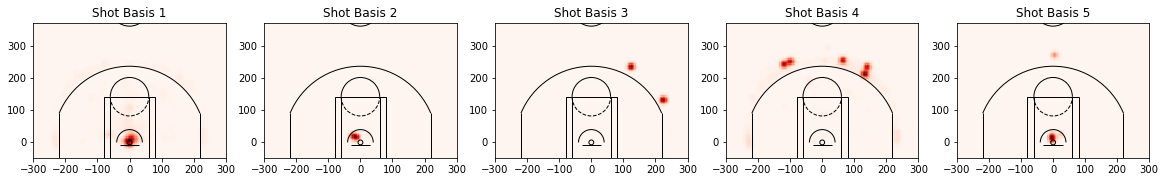

In [8]:
fig, ax = plt.subplots(1, 5, figsize=(20,60))
## Write a for loop
for i in range(5):
    mf.plot_vectorized_shotchart(W[:,i],xedges,yedges,ax = ax[i])
    ax[i].set_title('Shot Basis %i' % (i+1))

In [9]:
comp = []
for i in range(len(FPIDS)):
    comp.append([H[:,i]])
comp = pd.DataFrame(index = FPIDS, data = comp)
for i in FPIDS:
    if(i < 0):
        continue
    print("Player Name:",player_dict[i])
    print("Shots Taken Regular Season:",len(plyrsreg[i].index))
    print("Shots Taken Playoffs:",len(plyrs[i].index))
    print(comp.loc[i][0])
    print(comp.loc[-i][0])

Player Name: Jason Terry
Shots Taken Regular Season: 154
Shots Taken Playoffs: 5
[0.24120093 0.01043947 0.0547543  0.20909792 0.01654814]
[0.         0.         0.         1.69748822 0.        ]
Player Name: Manu Ginobili
Shots Taken Regular Season: 463
Shots Taken Playoffs: 37
[0.59620624 0.05458047 0.01235235 0.11181944 0.01751539]
[0.32739153 0.08514443 0.         0.11575914 0.05327816]
Player Name: Joe Johnson
Shots Taken Regular Season: 360
Shots Taken Playoffs: 17
[0.16218057 0.01381797 0.01307322 0.0826576  0.        ]
[0.25227117 0.00763603 0.         0.1135571  0.01731021]
Player Name: Carmelo Anthony
Shots Taken Regular Season: 1168
Shots Taken Playoffs: 72
[0.34121194 0.00329202 0.00786441 0.10764257 0.        ]
[0.36305379 0.04250111 0.01788564 0.12608615 0.0009246 ]
Player Name: David West
Shots Taken Regular Season: 378
Shots Taken Playoffs: 45
[0.64403156 0.0595734  0.         0.         0.082241  ]
[0.7614649  0.         0.         0.         0.18638163]
Player Name: Ma

## Playstyles between different quarters

In [71]:
# Create DataFrames will all shot data from regular season
shots =  []
tmp = []
flag = True
for i in PIDS:
    for j in range(4):
        if(len(plyrsreg[i].PERIOD.value_counts()) < 4  or plyrsreg[i].PERIOD.value_counts().iloc[j] < 2):
            flag = False
    if flag:
        temp = plyrsreg[i].copy()
        temp.drop(temp.index[temp.PERIOD>4],inplace = True) # To remove data that goes into overtime
        shots.append(temp)
    flag = True
periodShots = pd.concat(shots,ignore_index = True)

In [105]:
player_dict = {}
FPIDS = []
FPIDSloop = []
period = []
numShots = {}
all_smooth = []
for i in enumerate(periodShots.groupby(['PLAYER_ID','PERIOD'])):
    temp = i[1][1]
    #temp.drop([temp.PERIOD > 4])
    tmp, xedges, yedges = mf.bin_shots(temp, bin_edges=(xedges, yedges), density=True, sigma=2) #i[1][1] is df
    ## vectorize and store into list
    all_smooth += [tmp.reshape(-1)]
    if(temp.PLAYER_ID.iloc[0] not in FPIDS):
        FPIDS.append(temp.PLAYER_ID.iloc[0])
        player_dict[temp.PLAYER_ID.iloc[0]] = temp.PLAYER_NAME.iloc[0]
        numShots[temp.PLAYER_ID.iloc[0]] = []
    FPIDSloop.append(temp.PLAYER_ID.iloc[0])
    period.append(temp.PERIOD.iloc[0])
    numShots[temp.PLAYER_ID.iloc[0]].append(len(i[1][1]))
X = np.vstack(all_smooth).T
p,n = X.shape
print(p,n) # n is number of players, p is shot regions

15750 400


In [127]:
n = 10
W,H = mf.non_negative_marix_decomp(n,X)

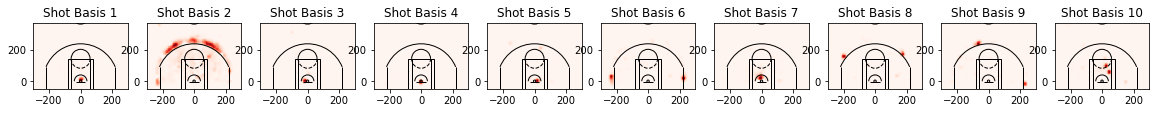

In [128]:
fig, ax = plt.subplots(1, 10, figsize=(20,60))
## Write a for loop
for i in range(n):
    mf.plot_vectorized_shotchart(W[:,i],xedges,yedges,ax = ax[i])
    ax[i].set_title('Shot Basis %i' % (i+1))
    
# We can see that many of the bases are variations of dunking, so we can choose to not care about these as much

In [129]:
comp = []
comprounded = []
for i in range(len(FPIDSloop)):
    comprounded.append([H[:,i].round(3)])
    comp.append([H[:,i]])
comp = pd.DataFrame(index = [FPIDSloop,period], data = comp)
comprounded = pd.DataFrame(index = [FPIDSloop,period], data = comprounded)
for i in FPIDS:
    print("Player Name:",player_dict[i])
    output = "Period 1: {} Period 2: {} Period 3: {} Period 4: {}"
    print("Shots Taken", output.format(numShots[i][0],numShots[i][1],numShots[i][2],numShots[i][3]))
    print(comprounded.loc[i])

Player Name: Jason Terry
Shots Taken Period 1: 25 Period 2: 52 Period 3: 26 Period 4: 50
                                                   0
1  [0.105, 0.374, 0.0, 0.033, 0.015, 0.566, 0.012...
2  [0.106, 0.381, 0.033, 0.017, 0.0, 0.403, 0.074...
3  [0.092, 0.444, 0.0, 0.0, 0.0, 0.154, 0.133, 0....
4  [0.004, 0.561, 0.006, 0.0, 0.0, 0.298, 0.038, ...
Player Name: Manu Ginobili
Shots Taken Period 1: 112 Period 2: 125 Period 3: 129 Period 4: 95
                                                   0
1  [0.084, 0.246, 0.223, 0.075, 0.077, 0.041, 0.0...
2  [0.107, 0.349, 0.128, 0.1, 0.039, 0.088, 0.159...
3  [0.099, 0.379, 0.13, 0.041, 0.053, 0.045, 0.12...
4  [0.097, 0.423, 0.156, 0.151, 0.046, 0.027, 0.0...
Player Name: Joe Johnson
Shots Taken Period 1: 73 Period 2: 99 Period 3: 99 Period 4: 86
                                                   0
1  [0.0, 0.379, 0.014, 0.015, 0.0, 0.079, 0.146, ...
2  [0.0, 0.245, 0.026, 0.011, 0.044, 0.15, 0.101,...
3  [0.005, 0.357, 0.004, 0.007, 0.003, 

Player Name: Jordan Mickey
Shots Taken Period 1: 14 Period 2: 26 Period 3: 15 Period 4: 27
                                                   0
1  [0.28, 0.0, 0.082, 0.112, 0.194, 0.041, 0.494,...
2  [0.349, 0.111, 0.141, 0.086, 0.051, 0.083, 0.3...
3  [0.297, 0.0, 0.277, 0.169, 0.129, 0.0, 0.47, 0...
4  [0.119, 0.181, 0.254, 0.05, 0.15, 0.081, 0.088...
Player Name: Dakari Johnson
Shots Taken Period 1: 14 Period 2: 4 Period 3: 6 Period 4: 15
                                                   0
1  [0.18, 0.0, 0.232, 0.342, 0.0, 0.0, 0.518, 0.0...
2  [0.513, 0.0, 0.278, 0.069, 0.228, 0.0, 0.152, ...
3  [0.127, 0.0, 0.0, 0.028, 0.0, 0.0, 0.954, 0.01...
4  [0.138, 0.0, 0.0, 0.24, 0.212, 0.0, 0.533, 0.0...
Player Name: Joe Young
Shots Taken Period 1: 23 Period 2: 61 Period 3: 22 Period 4: 80
                                                   0
1  [0.041, 0.186, 0.0, 0.07, 0.073, 0.113, 0.057,...
2  [0.145, 0.368, 0.074, 0.058, 0.0, 0.024, 0.167...
3  [0.132, 0.315, 0.0, 0.008, 0.049, 0.037,

## Defensive Players